##The first part:
###In this part, we will do feature selection and engineering.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#unzip the zip file of dataset
!unzip -q "/content/drive/MyDrive/Helmet Detection_datasets.zip" -d /content/

In [3]:
#put image model
from PIL import Image
Image.open("/content/images/BikesHelmets0.png").mode

'RGBA'

In [4]:
#import packages for data processing (extraction)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
from PIL import Image

In [5]:
# image path and xml path
XML_PATH = "/content/annotations"
IMG_PATH = "/content/images"
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [6]:
class XmlParser(object):
    def __init__(self, xml_file):
        # path to the xml file
        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall('object')
        # path to the image file as described in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()
    
    def parse_xml(self):
        tree = ET.parse(self.xml_file)
        return tree.getroot()
        
    
    def _get_names(self):
        names = []
        for obj in self._objects:
            name = obj.find('name')
            names.append(name.text)
        return np.array(names)
    
    def _get_bndbox(self):
        boxes = []
        for obj in self._objects:
            coordinates = [] # [xmin, ymin, xmax, ymax]
            bndbox = obj.find('bndbox')
            coordinates.append(np.int32(bndbox.find('xmin').text))
            coordinates.append(np.int32(bndbox.find('ymin').text))
            coordinates.append(np.int32(bndbox.find('xmax').text))
            coordinates.append(np.int32(bndbox.find('ymax').text))
            boxes.append(coordinates)
        return np.array(boxes)

In [7]:
#function for converting xml files to dataframes
def xml_files_to_df(xml_files):
    names = []
    boxes = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        # make sure the lenght of the files path is the same as that of the names
        xml_path.extend([xml.xml_file]*len(xml.names))
        img_path.extend([xml.img_path]*len(xml.names))
    return pd.DataFrame({'xml_path': xml_path,
                         'img_path': img_path,
                         'names': names,
                         'boxes': boxes})  

In [8]:
df = xml_files_to_df(XML_FILES)
df.head(5)

,xml_path,img_path,names,boxes
0,/content/annotations/BikesHelmets629.xml,/content/images/BikesHelmets629.png,With Helmet,"[181, 21, 230, 74]"
1,/content/annotations/BikesHelmets316.xml,/content/images/BikesHelmets316.png,With Helmet,"[121, 86, 175, 149]"
2,/content/annotations/BikesHelmets198.xml,/content/images/BikesHelmets198.png,Without Helmet,"[146, 22, 204, 83]"
3,/content/annotations/BikesHelmets684.xml,/content/images/BikesHelmets684.png,Without Helmet,"[87, 10, 142, 69]"
4,/content/annotations/BikesHelmets404.xml,/content/images/BikesHelmets404.png,Without Helmet,"[184, 10, 215, 42]"


In [9]:
#visualize the percentage of each category
df['names'].value_counts()/df['names'].count() * 100

With Helmet       66.299104
Without Helmet    33.700896
Name: names, dtype: float64

In [10]:
df['names'].value_counts()

With Helmet       962
Without Helmet    489
Name: names, dtype: int64

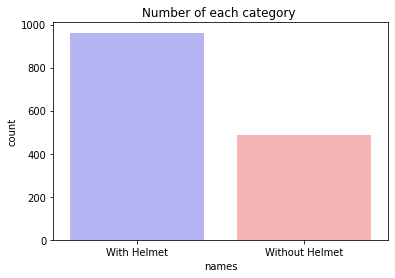

In [11]:
#visualize the Number of each category
import seaborn as sns
sns.countplot(x="names", data=df, palette="bwr").set(title='Number of each category ')
plt.show()

In [ ]:
#downloading the prepared dataframe for future training
#df.to_csv('final_dataframe.csv')

##The second part:
###we try to augment our images and randomly split our images into training, valiadation and testing set.

In [27]:
#import ImageDataGenerator to augment our dataset.
#resacle 1./255
#randomly sheer transforamtion
#randomly zooming inside pictures
#randomly flipping half of the images horizontally  

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

#here I don't augment test data here
test_datagen = ImageDataGenerator(rescale=1./255)


In [13]:
#see the sample result of augmentation
img = load_img('/content/images/BikesHelmets0.png')  
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)  
    
#generates batches of randomly transformed images
#saves the results to the `preview/` directory

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                                save_to_dir='preview', save_prefix='helmet', save_format='jpeg'):
  i += 1
  if i > 20:
    break 

In [28]:
#split data into training, validation and testing (0.9/0.09/0.01)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,train_size=0.9)
train_df, validation_df = train_test_split(train_df,train_size=0.9)
print("Training shape :\t",train_df.shape)
print("Validation shape :\t",validation_df.shape)
print("Testing X shape :\t",test_df.shape)

Training shape :	 (1174, 4)
Validation shape :	 (131, 4)
Testing X shape :	 (146, 4)


In [29]:
train_df.head()

,xml_path,img_path,names,boxes
1172,/content/annotations/BikesHelmets323.xml,/content/images/BikesHelmets323.png,With Helmet,"[181, 72, 242, 145]"
997,/content/annotations/BikesHelmets408.xml,/content/images/BikesHelmets408.png,Without Helmet,"[171, 49, 188, 72]"
661,/content/annotations/BikesHelmets530.xml,/content/images/BikesHelmets530.png,With Helmet,"[58, 31, 116, 107]"
932,/content/annotations/BikesHelmets449.xml,/content/images/BikesHelmets449.png,Without Helmet,"[313, 64, 336, 87]"
1123,/content/annotations/BikesHelmets489.xml,/content/images/BikesHelmets489.png,With Helmet,"[198, 107, 249, 166]"


In [30]:
#Import generator to read images from dataframe
#and generate batches of augmented image data 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

target_size = (128, 128) #set targe size

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              directory="/content/annotations",
                                              target_size=target_size,
                                              class_mode="binary",
                                              x_col="img_path",
                                              y_col="names",
                                              shuffle=True) #shuffle the original training data


val_gen = val_datagen.flow_from_dataframe(validation_df,
                                          directory="/content/annotations",
                                          target_size=target_size,
                                          class_mode="binary",
                                          x_col="img_path",
                                          y_col="names")


test_gen = test_datagen.flow_from_dataframe(test_df,
                                            directory="/content/annotations",
                                            target_size=target_size,
                                            class_mode="binary",
                                            x_col="img_path",
                                            y_col="names")

Found 1174 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.


##The third part:
###In this part, we will use several models to training our model, including CNN models and several transfer learning models. We gonna try several pre-trained model from imagenet competition. Since we do binary classification problems, not all models works well.

####Basic CNN model


In [ ]:
#We first defined a simple CNN model with two convultion layer and two pooling layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback 
from tensorflow.keras.optimizers import Adam

# Pile up layers. 
model=Sequential()
model.add(Conv2D(32, 3,input_shape=(128,128,3),activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 3,activation="relu"))
model.add(MaxPooling2D(2))

model.add(Flatten())                                                     
model.add(Dense(1,activation="sigmoid"))


# Compile model
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['acc'])

model._name = "CNN_model_basic"
#model summary
model.summary()


Model: "CNN_model_basic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 28800)             0         
                                                                 
 dense_11 (Dense)            (None, 1)             

In [ ]:
# Fit model
history_dense = model.fit(train_gen,
                          epochs=30, 
                          batch_size=8,
                          validation_data = val_gen)

Epoch 1/30
37/37 [==============================] - 47s 1s/step - loss: 0.6833 - acc: 0.6167 - val_loss: 0.6431 - val_acc: 0.6489
Epoch 2/30
37/37 [==============================] - 42s 1s/step - loss: 0.6308 - acc: 0.6644 - val_loss: 0.6786 - val_acc: 0.6489
Epoch 3/30
37/37 [==============================] - 42s 1s/step - loss: 0.6102 - acc: 0.6823 - val_loss: 0.6121 - val_acc: 0.6641
Epoch 4/30
37/37 [==============================] - 42s 1s/step - loss: 0.5809 - acc: 0.6925 - val_loss: 0.5914 - val_acc: 0.6336
Epoch 5/30
37/37 [==============================] - 43s 1s/step - loss: 0.5605 - acc: 0.7172 - val_loss: 0.6132 - val_acc: 0.6489
Epoch 6/30
37/37 [==============================] - 42s 1s/step - loss: 0.5249 - acc: 0.7368 - val_loss: 0.5990 - val_acc: 0.6641
Epoch 7/30
37/37 [==============================] - 42s 1s/step - loss: 0.5084 - acc: 0.7411 - val_loss: 0.6035 - val_acc: 0.7023
Epoch 8/30
37/37 [==============================] - 43s 1s/step - loss: 0.5034 - acc: 0.74

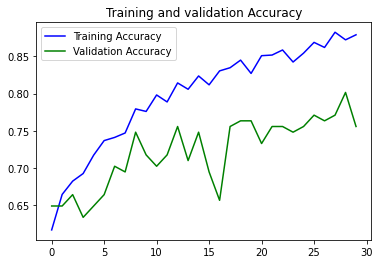

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_dense.history['acc'], color='b', label='Training Accuracy')
plt.plot(history_dense.history['val_acc'], color='g', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

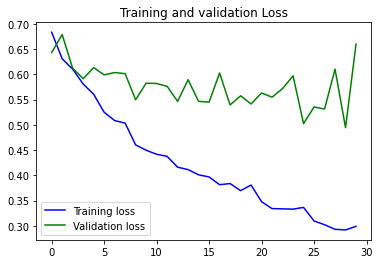

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_dense.history['loss'], color='b', label='Training loss')
plt.plot(history_dense.history['val_loss'], color='g', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

In [ ]:
#evaluate the accuracy based on test set
model.evaluate(test_gen)

5/5 [==============================] - 3s 551ms/step - loss: 0.6617 - acc: 0.7945


[0.661742627620697, 0.7945205569267273]

####Improved CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras

In [ ]:
# Pile up layers. 
model=Sequential()
model.add(Conv2D(128, 5, 3, input_shape=(128,128,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3,activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3,activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Flatten())                                                     
model.add(Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l2(10e-5)))
model.add(Dropout(0.5))
model.add(Dense(64,activation="relu",kernel_regularizer=keras.regularizers.l2(10e-5)))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))


# Compile model
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['acc'])

model._name = "CNN_model_improved"
#model summary
model.summary()

Model: "CNN_model_improved"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 42, 42, 128)       9728      
                                                                 
 batch_normalization_9 (Batc  (None, 42, 42, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 19, 19, 64)        73792     
                                                                 
 batch_normalization_10 (Bat  (None, 19, 19, 64)       256       
 chNormalization)                                                
                                                

In [ ]:
# Fit model
history_dense = model.fit(train_gen,
                          epochs=30, 
                          batch_size=8,
                          validation_data = val_gen)
model.save('cnn_improved_model.h5')

Epoch 1/30
37/37 [==============================] - 34s 874ms/step - loss: 0.9155 - acc: 0.5809 - val_loss: 0.6865 - val_acc: 0.6183
Epoch 2/30
37/37 [==============================] - 33s 874ms/step - loss: 0.7039 - acc: 0.6499 - val_loss: 0.7631 - val_acc: 0.4275
Epoch 3/30
37/37 [==============================] - 32s 870ms/step - loss: 0.6743 - acc: 0.6627 - val_loss: 0.8010 - val_acc: 0.3664
Epoch 4/30
37/37 [==============================] - 31s 835ms/step - loss: 0.6162 - acc: 0.6746 - val_loss: 0.6950 - val_acc: 0.5802
Epoch 5/30
37/37 [==============================] - 34s 906ms/step - loss: 0.5971 - acc: 0.7240 - val_loss: 0.8062 - val_acc: 0.3893
Epoch 6/30
37/37 [==============================] - 32s 872ms/step - loss: 0.5387 - acc: 0.7538 - val_loss: 0.7425 - val_acc: 0.5420
Epoch 7/30
37/37 [==============================] - 32s 869ms/step - loss: 0.5175 - acc: 0.7436 - val_loss: 0.7662 - val_acc: 0.5420
Epoch 8/30
37/37 [==============================] - 31s 841ms/step - 

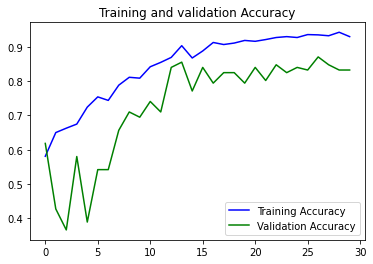

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_dense.history['acc'], color='b', label='Training Accuracy')
plt.plot(history_dense.history['val_acc'], color='g', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

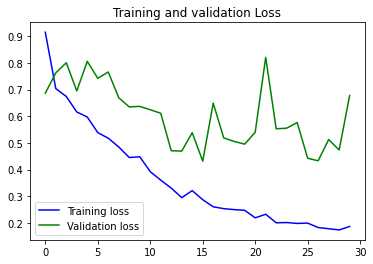

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_dense.history['loss'], color='b', label='Training loss')
plt.plot(history_dense.history['val_loss'], color='g', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

In [ ]:
#evaluate the accuracy based on test set
model.evaluate(test_gen)

5/5 [==============================] - 3s 496ms/step - loss: 0.9888 - acc: 0.8219


[0.9887574911117554, 0.8219178318977356]

####VGG16 model

In [ ]:
#Try VGG-16 pre-trained model here
from keras.applications.vgg16 import VGG16  
from keras.applications.vgg16 import preprocess_input
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))

#Freeze all the layers so that is not updated during training
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
#Add trainable dense layers
# Creating the output layers to train with our dataset
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

# Flatten the output layer to 1 dimension
X = Flatten()(vgg16.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
X = Dense(units=1024, activation='relu')(X)

# Add a dropout rate of 0.2
X = Dropout(0.2)(X)

# Add a final sigmoid layer for classification
X = Dense(1, activation='sigmoid')(X)

# Final Model
model = Model(vgg16.input, X)

# Compile Model
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model._name = "vgg16_basic"

# Model Summary
model.summary()

Model: "vgg16_basic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.01, decay=1e-6)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['acc'])

In [ ]:
# Fit model
history_dense = model.fit(train_gen,
                          epochs=30, 
                          batch_size=6,
                          validation_data = val_gen)

model.save('vgg16_model.h5')

Epoch 1/30
37/37 [==============================] - 241s 6s/step - loss: 6.8111 - acc: 0.6048 - val_loss: 0.4942 - val_acc: 0.7939
Epoch 2/30
37/37 [==============================] - 237s 6s/step - loss: 0.5969 - acc: 0.7223 - val_loss: 0.4722 - val_acc: 0.7710
Epoch 3/30
37/37 [==============================] - 237s 6s/step - loss: 0.4477 - acc: 0.7964 - val_loss: 0.4692 - val_acc: 0.7634
Epoch 4/30
37/37 [==============================] - 236s 6s/step - loss: 0.4358 - acc: 0.8015 - val_loss: 0.5721 - val_acc: 0.7328
Epoch 5/30
37/37 [==============================] - 236s 6s/step - loss: 0.4156 - acc: 0.7964 - val_loss: 0.3991 - val_acc: 0.8092
Epoch 6/30
37/37 [==============================] - 237s 6s/step - loss: 0.3500 - acc: 0.8450 - val_loss: 0.4548 - val_acc: 0.7634
Epoch 7/30
37/37 [==============================] - 237s 6s/step - loss: 0.3510 - acc: 0.8612 - val_loss: 0.3699 - val_acc: 0.8397
Epoch 8/30
37/37 [==============================] - 237s 6s/step - loss: 0.3546 - a

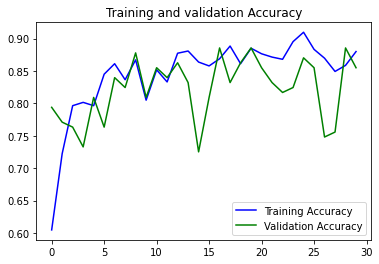

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_dense.history['acc'], color='b', label='Training Accuracy')
plt.plot(history_dense.history['val_acc'], color='g', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

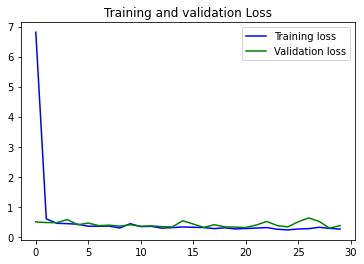

In [ ]:
#plot accuracy
import matplotlib.pyplot as plt
plt.plot(history_dense.history['loss'], color='b', label='Training loss')
plt.plot(history_dense.history['val_loss'], color='g', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_gen)

5/5 [==============================] - 26s 5s/step - loss: 0.6780 - acc: 0.7808


[0.6779763698577881, 0.7808219194412231]

####VGG19 model

In [ ]:
#Try VGG-19 pre-trained model here
from keras.applications.vgg19 import VGG19   
from keras.applications.vgg19 import preprocess_input
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

#Freeze all the layers so that is not updated during training
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
from keras.backend import dropout
#Add trainable dense layers
from keras.layers import Activation
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

flat_1 = Flatten()(vgg19.output)

# fc_1 = Dense(128)(flat_1)

# fc_2 = dropout(0.25)


fc_1 = Flatten()(flat_1)
fc_2 = Dense(256, activation='relu')(fc_1)
f1_3 = Dropout(0.25)(fc_2)
act_2 = Dense(units=1, activation='sigmoid')(f1_3)


In [ ]:
model = Model(inputs=vgg19.input, outputs=act_2)
model._name = "vgg19_model_basic"

model.summary()

Model: "vgg19_model_basic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128) 

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['acc'])

In [ ]:
# Fit model
history_dense = model.fit(train_gen,
                          epochs=30, 
                          batch_size=6,
                          validation_data = val_gen)
model.save('vgg19_model.h5')

Epoch 1/30
37/37 [==============================] - 290s 8s/step - loss: 0.8606 - acc: 0.6354 - val_loss: 0.6250 - val_acc: 0.6718
Epoch 2/30
37/37 [==============================] - 289s 8s/step - loss: 0.5387 - acc: 0.7181 - val_loss: 0.5927 - val_acc: 0.6794
Epoch 3/30
37/37 [==============================] - 288s 8s/step - loss: 0.4952 - acc: 0.7470 - val_loss: 0.5976 - val_acc: 0.6947
Epoch 4/30
37/37 [==============================] - 288s 8s/step - loss: 0.4531 - acc: 0.7964 - val_loss: 0.5412 - val_acc: 0.7328
Epoch 5/30
37/37 [==============================] - 287s 8s/step - loss: 0.4249 - acc: 0.8041 - val_loss: 0.5237 - val_acc: 0.7481
Epoch 6/30
37/37 [==============================] - 288s 8s/step - loss: 0.4393 - acc: 0.7913 - val_loss: 0.5618 - val_acc: 0.7176
Epoch 7/30
37/37 [==============================] - 288s 8s/step - loss: 0.3806 - acc: 0.8313 - val_loss: 0.5498 - val_acc: 0.7328
Epoch 8/30
37/37 [==============================] - 289s 8s/step - loss: 0.3685 - a

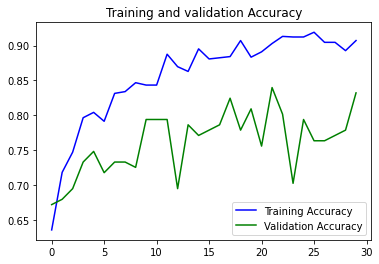

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_dense.history['acc'], color='b', label='Training Accuracy')
plt.plot(history_dense.history['val_acc'], color='g', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

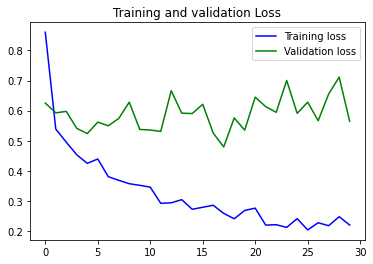

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_dense.history['loss'], color='b', label='Training loss')
plt.plot(history_dense.history['val_loss'], color='g', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_gen)

5/5 [==============================] - 32s 6s/step - loss: 0.4085 - acc: 0.8425


[0.40851500630378723, 0.8424657583236694]

####InceptionV3 model


In [31]:
from keras.applications.inception_v3 import InceptionV3

In [32]:
# Making an instance of the pre-trained model
inception_model = InceptionV3(input_shape=(128, 128, 3),
                              include_top=False,
                              weights='imagenet')

In [33]:
# Making all the layers non trainable
for layer in inception_model.layers:
  layer.trainable = False

In [34]:
# Creating the output layers to train with our dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

# Flatten the output layer to 1 dimension
X = Flatten()(inception_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation


# Add a final sigmoid layer for classification
X = Dense(1, activation='sigmoid')(X)

# Final Model
model = Model(inception_model.input, X)

# Compile Model
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model._name = "inception_model_basic"

# Model Summary
model.summary()

Model: "inception_model_basic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                              

In [35]:
# Fit model
history_dense = model.fit(train_gen,
                          epochs=30, 
                          batch_size=6,
                          validation_data = val_gen)
model.save('inception_model.h5')

Epoch 1/30
37/37 [==============================] - 62s 2s/step - loss: 1.1292 - accuracy: 0.6184 - val_loss: 0.9874 - val_accuracy: 0.6870
Epoch 2/30
37/37 [==============================] - 54s 1s/step - loss: 0.5199 - accuracy: 0.7845 - val_loss: 0.4749 - val_accuracy: 0.7939
Epoch 3/30
37/37 [==============================] - 53s 1s/step - loss: 0.3630 - accuracy: 0.8390 - val_loss: 0.4588 - val_accuracy: 0.7863
Epoch 4/30
37/37 [==============================] - 53s 1s/step - loss: 0.2701 - accuracy: 0.8782 - val_loss: 0.3857 - val_accuracy: 0.8397
Epoch 5/30
37/37 [==============================] - 53s 1s/step - loss: 0.2426 - accuracy: 0.8876 - val_loss: 0.3660 - val_accuracy: 0.8702
Epoch 6/30
37/37 [==============================] - 53s 1s/step - loss: 0.2150 - accuracy: 0.9080 - val_loss: 0.3709 - val_accuracy: 0.8702
Epoch 7/30
37/37 [==============================] - 53s 1s/step - loss: 0.2131 - accuracy: 0.9063 - val_loss: 0.3495 - val_accuracy: 0.8397
Epoch 8/30
37/37 [==

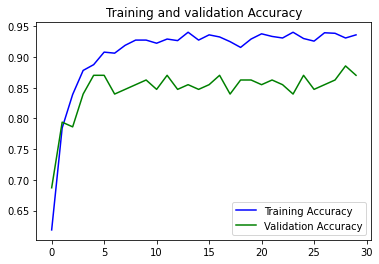

In [36]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_dense.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history_dense.history['val_accuracy'], color='g', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

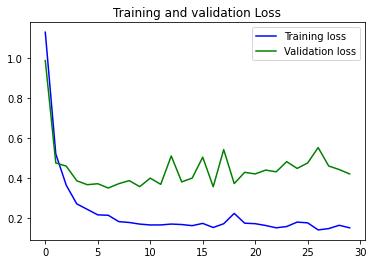

In [37]:
#plot accuracy
import matplotlib.pyplot as plt
plt.plot(history_dense.history['loss'], color='b', label='Training loss')
plt.plot(history_dense.history['val_loss'], color='g', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

In [38]:
#evaluate the accuracy based on test set
model.evaluate(test_gen)

5/5 [==============================] - 6s 1s/step - loss: 0.6485 - accuracy: 0.8493


[0.6485176086425781, 0.8493150472640991]